In [1]:
# import dataframe and array packages
import pandas as pd
import numpy as np

#import modeling functions
from sklearn import datasets, linear_model, metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split

#import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# import other necessary packages
import datetime
import random
import time

In [2]:
# load match data into dataframe
df = pd.read_csv("spi_matches.csv")

# load team data into dataframe
df_spi = pd.read_csv("spi_global_rankings.csv")
df_spi = df_spi[["name", "spi"]]

In [3]:
# select parameters

# designate target league id
target_league_id = 2411 # League Name: Premier League

# designate positions for champions league, europa league, relegation, etc.
ucl_places = [1, 2, 3, 4, 5]
el_places = [6, 7, 8]
relegation_playoff_places = []
relegation_places = [18, 19, 20]

# select number of simulations to perform
sim_count = 10000

# select teams in target matchup
team_01 = "Crystal Palace"
team_02 = "Burnley"

In [4]:
# setup data for regression

# narrow down dataframe to matches just in target league
df = df[df.league_id == target_league_id]
df = df.reset_index(drop=True)
# narrow down dataframe to just relevant columns
df = df[["spi1", "spi2", "prob1", "prob2", "probtie"]]
df.index.name = "match_index"

# select independent and dependent variables
X = df[["spi1", "spi2"]]
Y_1 = df["prob1"]
Y_2 = df["prob2"]
Y_tie = df["probtie"]

# split dataset into training and test sets for X and Y_1
x_train, x_test, y_1_train, y_1_test = train_test_split(X, Y_1, test_size=0.2, random_state=1)

# match splits for Y_2 and Y_tie
indices_train = y_1_train.index
indices_test = y_1_test.index
y_2_train = Y_2.iloc[indices_train]
y_2_test = Y_2.iloc[indices_test]
y_tie_train = Y_tie.iloc[indices_train]
y_tie_test = Y_tie.iloc[indices_test]

In [5]:
# perform and measure regression for different orders of polynomials

# create empty lists to store R^2 scores in
scores_1_test = []
scores_2_test = []
scores_tie_test = []

# select range of orders of polynomial to be tested
orders = list(range(1,6))

# calculate R^2 for each order for each of the three dependent variables
for n in orders:
    pr = PolynomialFeatures(degree=n)
    x_train_pr = pr.fit_transform(x_train[["spi1", "spi2"]])
    x_test_pr = pr.fit_transform(x_test[["spi1", "spi2"]])
    # team 1 win prob regression
    poly1 = LinearRegression()
    poly1.fit(x_train_pr, y_1_train)
    score_1_test = poly1.score(x_test_pr, y_1_test)
    scores_1_test.append(score_1_test)
    # team 2 win prob regression
    poly2 = LinearRegression()
    poly2.fit(x_train_pr, y_2_train)
    score_2_test = poly2.score(x_test_pr, y_2_test)
    scores_2_test.append(score_2_test)
    # tie prob regression
    polytie = LinearRegression()
    polytie.fit(x_train_pr, y_tie_train)
    score_tie_test = polytie.score(x_test_pr, y_tie_test)
    scores_tie_test.append(score_tie_test)

# find order that has the highest average R^2 between the three regressions
scores_avg = (np.array(scores_1_test) + np.array(scores_2_test) + np.array(scores_tie_test))/3
order_max = list(scores_avg).index(scores_avg.max())

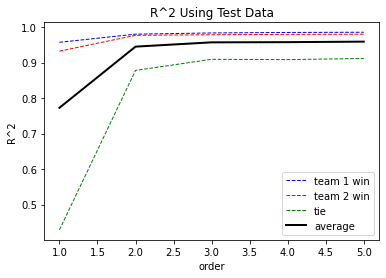

In [6]:
# plot graph of order vs R^2 for the test data
plt.plot(orders, scores_1_test, 'b--', label="team 1 win", linewidth=1)
plt.plot(orders, scores_2_test, 'r--', label="team 2 win", linewidth=1)
plt.plot(orders, scores_tie_test, 'g--', label="tie", linewidth=1)
plt.plot(orders, scores_avg, 'k', label="average", linewidth=2)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')
plt.legend()

In [7]:
# generate polynomial features for ridge reduction testing
pr = PolynomialFeatures(degree=order_max)
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.fit_transform(x_test)
# select possible alphas
alphas = [0, .001, .003, .01, .03, .1, .3, 1, 3, 10]
# setup lists for scores
r2_1_test = []
r2_2_test = []
r2_tie_test = []
# perform ridge regression over variety of alpha values
for n in alphas:
    # team 1 win ridge regression
    RigeModel1 = Ridge(alpha=n) 
    RigeModel1.fit(x_train_pr, y_1_train)
    r2_1_test.append(RigeModel1.score(x_test_pr, y_1_test))
    # team 2 win ridge regression
    RigeModel2 = Ridge(alpha=n) 
    RigeModel2.fit(x_train_pr, y_2_train)
    r2_2_test.append(RigeModel2.score(x_test_pr, y_2_test))
    # team 1 win ridge regression
    RigeModeltie = Ridge(alpha=n) 
    RigeModeltie.fit(x_train_pr, y_tie_train)
    r2_tie_test.append(RigeModeltie.score(x_test_pr, y_tie_test))

c:\users\kenne\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.71044e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\users\kenne\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.71044e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\users\kenne\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.71044e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\users\kenne\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.91313e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\users\kenne\appdata\local\programs\python\pyt

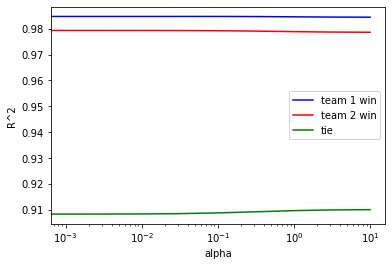

In [8]:
# plot alpha vs R^2 for all three regressions
plt.plot(alphas, r2_1_test, 'b', label='team 1 win')
plt.plot(alphas, r2_2_test, 'r', label='team 2 win')
plt.plot(alphas, r2_tie_test, 'g', label='tie')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.xscale('log')
plt.legend()

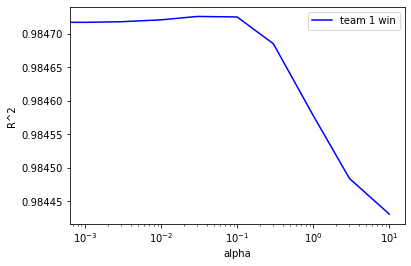

In [9]:
# plot alpha vs R^2 for just team 1 win
plt.plot(alphas, r2_1_test, 'b', label='team 1 win')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.xscale('log')
plt.legend()

# ridge regression makes very little difference on R^2 of test data

In [10]:
# generate final regression models
# team 1 win model
poly1 = LinearRegression()
poly1.fit(x_train_pr, y_1_train)
# team 2 win model
poly2 = LinearRegression()
poly2.fit(x_train_pr, y_2_train)
# tie model
polytie = LinearRegression()
polytie.fit(x_train_pr, y_tie_train)

# generate predictions from model
yhat_1_test = poly1.predict(x_test_pr)
yhat_2_test = poly2.predict(x_test_pr)
yhat_tie_test = polytie.predict(x_test_pr)

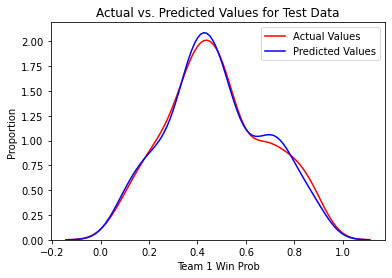

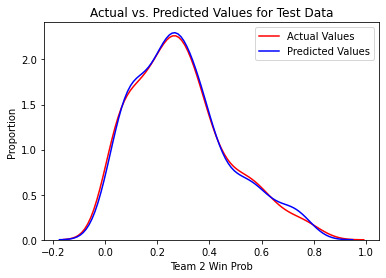

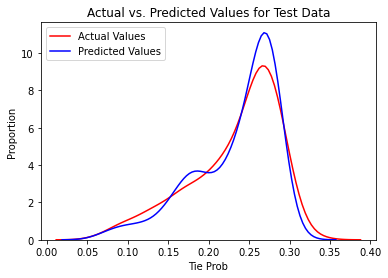

In [11]:
# generate plots to show accuracy of models

# plot data with model for team 1 win
ax1 = sns.distplot(y_1_test, hist=False, color="r", label="Actual Values")
ax2 = sns.distplot(yhat_1_test, hist=False, color="b", label="Predicted Values", ax=ax1)
plt.title("Actual vs. Predicted Values for Test Data")
plt.xlabel('Team 1 Win Prob')
plt.ylabel('Proportion')
plt.show()
plt.close()
# plot data with model for team 2 win
ax1 = sns.distplot(y_2_test, hist=False, color="r", label="Actual Values")
ax2 = sns.distplot(yhat_2_test, hist=False, color="b", label="Predicted Values", ax=ax1)
plt.title("Actual vs. Predicted Values for Test Data")
plt.xlabel('Team 2 Win Prob')
plt.ylabel('Proportion')
plt.show()
plt.close()
# plot data with model for tie
ax1 = sns.distplot(y_tie_test, hist=False, color="r", label="Actual Values")
ax2 = sns.distplot(yhat_tie_test, hist=False, color="b", label="Predicted Values", ax=ax1)
plt.title("Actual vs. Predicted Values for Test Data")
plt.xlabel('Tie Prob')
plt.ylabel('Proportion')
plt.show()
plt.close()

In [12]:
# load matches, select revelant data, compute points

# load match data into dataframe
df = pd.read_csv("spi_matches.csv")

# narrow down dataframe to matches just in target league
df = df[df.league_id == target_league_id]
df = df.reset_index(drop=True)

# narrow down dataframe to just relevant columns
df = df[["date", "team1", "team2", "score1", "score2"]]
df.index.name = "match_index"
df['date']= pd.to_datetime(df['date'])

# narrow down dataframe to matches (rows) from present season
start_date = datetime.datetime(2019, 7, 31)
df = df[(df["date"] > start_date)]
df = df.reset_index(drop=True)

# create columns to calculate each team's point
df.insert(5, "points1", 0)
df.insert(6,"points2", 0)

# calculate how many points each team gets for a match
df.loc[df["score1"] > df["score2"], "points1"] = 3
df.loc[df["score1"] < df["score2"], "points2"] = 3
df.loc[df["score1"] == df["score2"], "points1"] = 1
df.loc[df["score1"] == df["score2"], "points2"] = 1

In [13]:
# generate sorted list of teams in league
teams = df["team1"].unique()
teams = pd.DataFrame(teams)
teams.columns = ["name"]
teams = teams.sort_values(by=["name"])
teams = teams.reset_index(drop=True)
teams.insert(1, "points", 0)

In [14]:
# define functions for simulating league

# calculate each team's points and spi, returns table of teams
def table_calc(teams, matches, teams_spi):
    teams1 = teams.copy()
    points = []
    spis = []
    for team in teams1["name"]:
        df_spi_team = teams_spi[teams_spi.name == team]
        spi = df_spi_team.iloc[0,1]
        spis.append(spi)
    df_home = np.array(matches.groupby(["team1"])["points1"].sum())
    df_away = np.array(matches.groupby(["team2"])["points2"].sum())
    teams1["points"] = df_home + df_away
    teams1["spi"] = spis
    return teams1

# setup dataframe for simulating, returns games to be simulated
def sim_setup(matches, teams):
    df_left = matches[(matches["score1"].isnull())]
    df_left = df_left[["date", "team1", "team2", "points1", "points2"]]
    df_left = pd.merge(df_left, teams, how="left", left_on="team1", right_on="name")
    df_left = df_left.drop(["points", "name"], 1)
    df_left = pd.merge(df_left, teams, how="left", left_on="team2", right_on="name")
    df_left = df_left.drop(["points", "name"], 1)
    df_left = df_left.rename(columns={"spi_x": "spi1", "spi_y": "spi2"})
    df_left.insert(7, "random", 0)
    df_left.insert(8, "prob1", 0)
    df_left.insert(9, "prob2", 0)
    return df_left

# simulate remainder of games in a season; returns simulated games
def sim_remaining(df_left, transform_fit, poly1, poly2):
    df_left_sim = df_left.copy()
    m = len(df_left_sim)
    random_numbers = [random.random() for i in range(m)]
    df_left_sim["random"] = random_numbers
    spi12 = df_left_sim[["spi1", "spi2"]]
    spi12 = transform_fit.fit_transform(spi12)
    prob1 = poly1.predict(spi12)
    df_left_sim["prob1"] = prob1
    prob2 = poly2.predict(spi12)
    df_left_sim["prob2"] = prob1 + prob2
    df_left_sim.loc[df_left_sim["random"] <= df_left_sim["prob1"], "points1"] = 3
    df_left_sim.loc[df_left_sim["random"] > df_left_sim["prob1"], "points2"] = 3
    df_left_sim.loc[df_left_sim["random"] > df_left_sim["prob2"], "points1"] = 1
    df_left_sim.loc[df_left_sim["random"] > df_left_sim["prob2"], "points2"] = 1
    return df_left_sim

# simulate n number of leagues; returns compiled team table and compiled match results
def sim_comp(matches, teams, sim_count1, transform_fit, poly1, poly2, teams_spi):
    df_left_sim2 = sim_setup(matches, teams)
    teams_sim2 = teams.copy()
    teams_sim2 = teams_sim2[["name"]]
    match_results2 = df_left_sim2.copy()
    match_results2 = match_results2[["date"]]
    number_teams = len(teams)
    for i in range(sim_count1):
        df_left2 = sim_remaining(df_left_sim2, transform_fit, poly1, poly2)
        teams_new2 = table_calc(teams_sim2, df_left2, teams_spi)
        random_numbers2 = [random.random() for i in range(number_teams)]
        teams_new2 = teams_new2["points"] + teams["points"] + random_numbers2
        teams_sim2[str("points_" + str(i))] = teams_new2.rank(ascending=False, method="min")
        match_results2[str("sim_" + str(i))] = df_left2["points1"]
    return teams_sim2, match_results2

# calculate probabilities of different season results for each team; returns table of probabilities for each team
def sim_comp_results(teams, teams_sim):
    teams_result = teams.copy()
    teams_result = teams_result[["name"]]
    teams_sim_result = teams_sim.copy()
    a, b = teams_sim_result.shape
    sim_count1 = b - 1
    teams_result["first"] = ((teams_sim_result == 1).astype(float)).sum(axis=1)/sim_count1
    teams_result["cl"] = ((teams_sim_result.isin(ucl_places)).astype(float)).sum(axis=1)/sim_count1
    teams_result["el"] = ((teams_sim_result.isin(el_places)).astype(float)).sum(axis=1)/sim_count1
    teams_result["playoff"] = ((teams_sim_result.isin(relegation_playoff_places)).astype(float)).sum(axis=1)/sim_count1
    teams_result["rel"] = ((teams_sim_result.isin(relegation_places)).astype(float)).sum(axis=1)/sim_count1
    return teams_result

In [15]:
# calculate current table
teams = table_calc(teams, df, df_spi)

# calculate simulated table
df_left = sim_setup(df, teams)
df_left = sim_remaining(df_left, pr, poly1, poly2)
teams_new = table_calc(teams, df_left, df_spi)
teams_new["points"] = teams_new["points"] + teams["points"]
teams, teams_new

(                        name  points    spi
 0            AFC Bournemouth      27  63.65
 1                    Arsenal      43  77.25
 2                Aston Villa      27  62.30
 3   Brighton and Hove Albion      33  71.45
 4                    Burnley      42  70.59
 5                    Chelsea      54  86.92
 6             Crystal Palace      42  69.70
 7                    Everton      41  78.42
 8             Leicester City      55  81.32
 9                  Liverpool      86  92.83
 10           Manchester City      63  94.66
 11         Manchester United      49  88.01
 12                 Newcastle      39  63.67
 13              Norwich City      21  59.93
 14          Sheffield United      44  69.19
 15               Southampton      40  70.96
 16         Tottenham Hotspur      45  76.94
 17                   Watford      28  70.91
 18           West Ham United      27  65.78
 19             Wolverhampton      52  82.16,
                         name  points    spi
 0       

In [16]:
# simulate league n times and record time taken
start_time0 = time.time()
teams_sim, match_results = sim_comp(df, teams, sim_count, pr, poly1, poly2, df_spi)
end_time0 = time.time()
print((end_time0 - start_time0))
match_results = match_results.transpose().reset_index()

# compile all simulations
teams_result = sim_comp_results(teams, teams_sim)
teams_result

678.3239738941193


,name,first,cl,el,playoff,rel
0,AFC Bournemouth,0.0,0.0000,0.0000,0.0,0.5971
1,Arsenal,0.0,0.0035,0.4113,0.0,0.0000
2,Aston Villa,0.0,0.0000,0.0000,0.0,0.7578
3,Brighton and Hove Albion,0.0,0.0000,0.0001,0.0,0.0110
4,Burnley,0.0,0.0004,0.1733,0.0,0.0000
5,Chelsea,0.0,0.9413,0.0587,0.0,0.0000
6,Crystal Palace,0.0,0.0004,0.0988,0.0,0.0000
7,Everton,0.0,0.0023,0.3506,0.0,0.0000
8,Leicester City,0.0,0.8730,0.1269,0.0,0.0000
9,Liverpool,1.0,1.0000,0.0000,0.0,0.0000


In [17]:
# find match id for desired matchup and create lists of simulations grouped by result in target match
match_idx = df_left[(df_left.team1 == team_01) & (df_left.team2 == team_02)].index.tolist()[0]
team1_win = [0] + match_results[(match_results.iloc[:,(match_idx + 1)] == 3)].index.tolist()
team2_win = [0] + match_results[(match_results.iloc[:,(match_idx + 1)] == 0)].index.tolist()
team_draw = [0] + match_results[(match_results.iloc[:,(match_idx + 1)] == 1)].index.tolist()

In [18]:
# group simulations by result of target match and compute season probabilities

# simulations in which team 1 wins
teams_sim1 = teams_sim.iloc[:, team1_win]
sim_comp1 = sim_comp_results(teams, teams_sim1)
sim_comp1.insert(0, "result", str("1- " + team_01 + " win"))
# simulations in which team 2 wins
teams_sim2 = teams_sim.iloc[:, team2_win]
sim_comp2 = sim_comp_results(teams, teams_sim2)
sim_comp2.insert(0, "result", str("2- " + team_02 + " win"))
# simulations in which teams draw
teams_simdraw = teams_sim.iloc[:, team_draw]
sim_compdraw = sim_comp_results(teams, teams_simdraw)
sim_compdraw.insert(0, "result", "draw")

# compare season probabilities for all three possible outcomes
sim_comps = [sim_comp1, sim_compdraw, sim_comp2]
sim_comp12 = pd.concat(sim_comps)
sim_comp12 = sim_comp12.sort_values(["name", "result"])
print("team 1: " + team_01)
print("team 2: " + team_02)
sim_comp12

team 1: Crystal Palace
team 2: Burnley


,result,name,first,cl,el,playoff,rel
0,1- Crystal Palace win,AFC Bournemouth,0.0,0.000000,0.000000,0.0,0.605653
0,2- Burnley win,AFC Bournemouth,0.0,0.000000,0.000000,0.0,0.593739
0,draw,AFC Bournemouth,0.0,0.000000,0.000000,0.0,0.587173
1,1- Crystal Palace win,Arsenal,0.0,0.004402,0.415199,0.0,0.000000
1,2- Burnley win,Arsenal,0.0,0.002693,0.383373,0.0,0.000000
1,draw,Arsenal,0.0,0.002949,0.435680,0.0,0.000000
2,1- Crystal Palace win,Aston Villa,0.0,0.000000,0.000000,0.0,0.759963
2,2- Burnley win,Aston Villa,0.0,0.000000,0.000000,0.0,0.750252
2,draw,Aston Villa,0.0,0.000000,0.000000,0.0,0.762624
3,1- Crystal Palace win,Brighton and Hove Albion,0.0,0.000000,0.000232,0.0,0.007414
